In [2]:
import sys
from fancy_einsum import einsum

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformers import AutoTokenizer, pipeline, logging, AutoModelForCausalLM, AutoConfig
from transformer_lens import ActivationCache, HookedTransformer

from huggingface_hub import notebook_login
from datasets import Dataset
import pandas as pd
import transformers
import torch
import einops  # Make sure einops is imported
import numpy as np 

from neel_plotly import line, imshow, scatter
import transformer_lens.patching as patching
import circuitsvis as cv
import matplotlib.pyplot as plt
from pathlib import Path
# Import from local libraries

from utils import *

from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model
# Method to calculate ID
import argparse
import json


In [1]:

def get_ratios(vectors, n_neighbors):
    try:
        N = len(vectors)
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="auto").fit(vectors)
        distances, indices = nbrs.kneighbors(vectors)
        ratios = np.array(
            [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
        )

    except Exception as e:
        print(f"An error occurred: {e}")
        ratios = None
        N = 0

    return ratios, N


def measure_dimension_kNN(
    vectors, n_neighbors=5, fraction=0.9, plot=False, verbose=False
):
    ratios, N = get_ratios(vectors, n_neighbors)
    try:
        mus = [
            np.sort(ratios[i], axis=None, kind="quicksort") for i in range(n_neighbors - 2)
        ]
        Femp = (np.arange(1, N + 1, dtype=np.float64)) / N

        dims = []
        xs = []
        ys = []
        regrs =[]
        for k, mu in enumerate(mus):
            x = np.log(mu[:-2])
            xs += [x]
            y = -np.log(1 - Femp[:-2] ** (1 / (k + 1)))
            ys += [y]

            npoints = int(np.floor(N * fraction))
            regr = linear_model.LinearRegression(fit_intercept=False)
            regr.fit(x[:npoints, np.newaxis], y[:npoints, np.newaxis])
            if verbose:
                print(
                    "From ratio " + str(k + 2) + " NN estimated dim " + str(regr.coef_[0])
                )
            dims += [regr.coef_[0]]
            regrs += [regr]

        if plot:
            fig, ax = plt.subplots(figsize=(7, 7))
            ax.set_title("Log F vs Log mu")
            ax.set_xscale("linear")
            ax.set_yscale("linear")
            for x, y, dim, regr in zip(xs, ys, dims, regrs):
                ax.scatter(x[:npoints], y[:npoints])
                ax.plot(
                    x[:npoints], regr.predict(x[:npoints].reshape((-1, 1))), color="gray"
                )
                ax.text(x[0],y[0], f'Dim {dim}', fontsize=14, color='blue')
        else : 
            fig = None
        #print(x[:npoints],regr.predict(x[:npoints].reshape((-1, 1)) ))
        return xs, ys, dims, regrs, npoints, fig
    except:
        return None, None, None, None, None, None


def measure_dimension_MLE(vectors, n_neighbors=10, plot=False, verbose=False):
    ratios, _ = get_ratios(vectors, n_neighbors)
    logs = np.log(ratios)
    estimates = (n_neighbors - 2) / (logs[:, -1] - np.sum(logs[:, :-1], axis=1))
    dim = np.mean(estimates)
    var = np.var(estimates)
    if verbose:
        print("Dimension MLE: ", dim, " Stddev: ", np.sqrt(var))
    if plot:
        fig, axs = plt.subplots(1, 1)
        axs.hist(estimates, bins=50)

    return dim, var, estimates

if True:
    last_idxs= torch.load(Path(project_name)/'last_idxs.pt')
    
    import itertools
    import pickle
    from sklearn.neighbors import NearestNeighbors
    from sklearn import linear_model
    
    # Use itertools.product to create combinations
    last_token_ind=1023
    fraction=0.1
    keys=[]
    dims_dict={}
    # Print each combination
    for str_i,str_j in list(itertools.product(names_filter, final_activations.keys()))[:]:
        key=f"{str_i}.{str_j}"
        file=key+".pt"
        activation_tensors0 = torch.load(Path(project_name)/file)
        filtered_data_idx=(np.array(last_idxs)==last_token_ind)
        activation_tensors_filtered=activation_tensors0[filtered_data_idx,:]

        xs, ys, dims, regrs, npoints, fig = measure_dimension_kNN(
            activation_tensors_filtered, n_neighbors=5, fraction=fraction, plot=True, verbose=True
        )

        if fig is not None:
            fig.savefig(Path(project_name) / ('plot_ID_'+file.replace(".pt", ".png")))

        dims_dict[key]=dims
        keys+=[key]

    Dimension_analyzed={
        "positions" :list(final_activations.keys()),
        "layer_keys" :target_layers_substrings,
        "layer_ind":layer_indices,
        "names_filter" : names_filter,
        "keys":keys,
        "dims":dims_dict,
        "last_token_ind":last_token_ind,
        "filtered_data_idx":filtered_data_idx,
        "fraction":fraction,
        "sample_num" : len(filtered_data_idx),
        "filtered_sample_num": sum(filtered_data_idx)
    }

    with open(Path(project_name)/'Dimension_analyzed.pkl', 'wb') as f:
        pickle.dump(Dimension_analyzed, f)



NameError: name 'torch' is not defined

In [9]:
parser = argparse.ArgumentParser(description='Run model with dataset.')

parser.add_argument('--session_name', type=str, required=True, help='Name of the session')
parser.add_argument('--model_name', type=str, required=True, help='Name of the model')
parser.add_argument('--model_checkpoint', type=str, required=True, help='Checkpoint of the model')
parser.add_argument('--dataset_name', type=str, required=True, help='Name of the dataset')
parser.add_argument('--dataset_subset', type=int, nargs='*', required=True, help='Subset of the dataset')
parser.add_argument('--tokens_min_length', type=int, required=True, help='Minimum length of tokens in the dataset')

#args = parser.parse_args()
#print(args)

#main("test", model_name="olmo-1b", model_checkpoint="main", dataset_name='pile_uncopyrighted_parquet', dataset_subset=[0,1], tokens_min_length=1024)
class Args:
    session_name = "20240607_234230_olmo-1b_main_openwebtext_parquet_0"
    model_name = "olmo-1b"
    model_checkpoint = "main"
    dataset_name = 'pile_uncopyrighted_parquet'
    dataset_subset = [0, 1]
    tokens_min_length = 1024

args = Args()

In [29]:
from pathlib import Path
def load_cache_from_file(file_path, dim, dtype=torch.float32):
    tensors = []
    with open(file_path, 'rb') as f:
        while True:
            len_bytes = f.read(4)
            if not len_bytes:
                break
            length = int.from_bytes(len_bytes, byteorder='big')
            tensor_bytes = f.read(length)
            tensor = np.frombuffer(tensor_bytes, dtype=np.float32)
            tensor = tensor.reshape(-1, dim)
            tensors.append(tensor)
        
    return np.concatenate(tensors)

In [48]:
session_path = Path(f"Data/{args.session_name}")  # Update this to your desired path

with open(session_path / 'config.json', 'r') as f:
    config=json.load(f)

ctx_len=2048
CREloss=load_cache_from_file(session_path / 'CREloss.pt', ctx_len-1)
Entropy=load_cache_from_file(session_path / 'Entropy.pt', ctx_len-1)

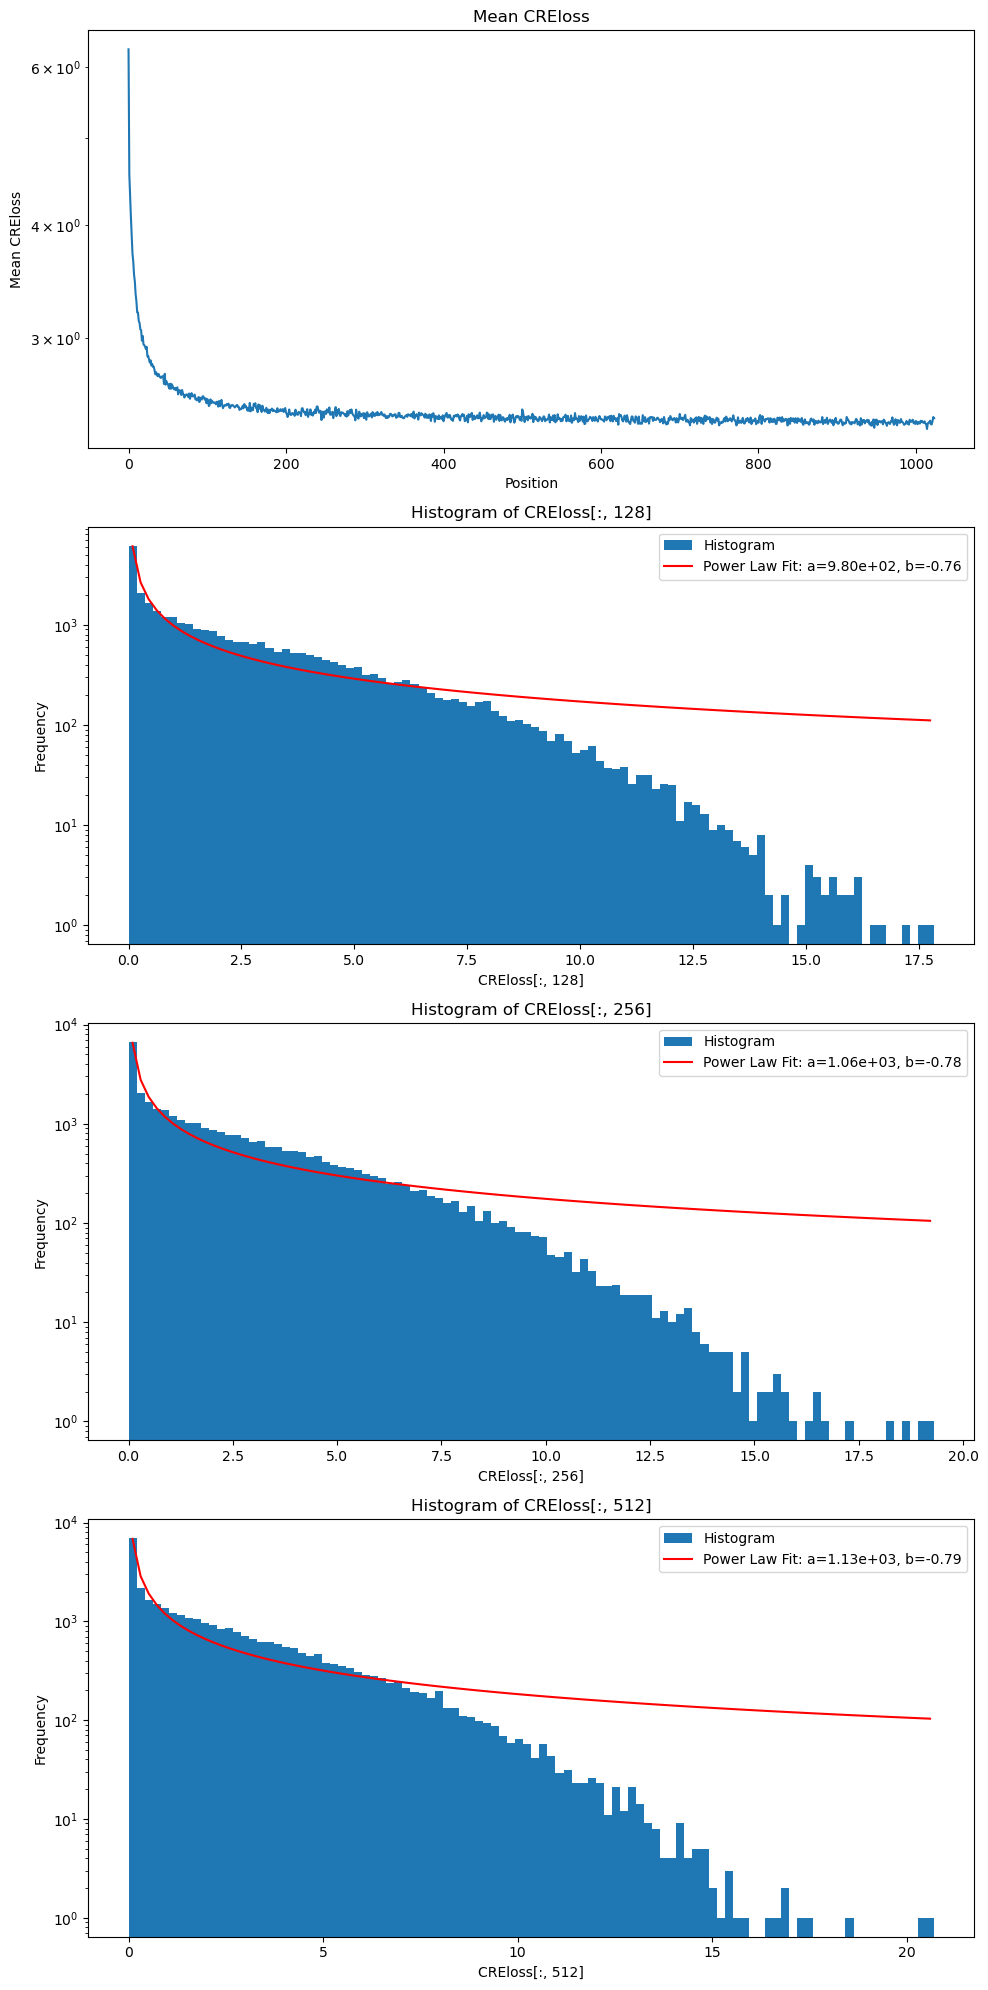

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assuming CREloss is a NumPy array
# Example: CREloss = np.random.rand(2000, 2048)  # Replace this with your actual data

# Define power law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Calculate the mean across the first axis
mean_CREloss = np.mean(CREloss, axis=0)

# Create a figure with subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot the mean CREloss
axs[0].plot(np.arange(1024), mean_CREloss[:1024])
axs[0].set_yscale('log')
axs[0].set_xlabel('Position')
axs[0].set_ylabel('Mean CREloss')
axs[0].set_title('Mean CREloss')

# Histograms and power law fitting for specific columns
columns = [128, 256, 512]
for i, col in enumerate(columns, 1):
    # Plot histogram
    hist, bins, _ = axs[i].hist(CREloss[:, col], bins=100, log=True, label='Histogram')
    
    # Calculate bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Fit power law to histogram data
    popt, _ = curve_fit(power_law, bin_centers, hist, maxfev=10000)
    
    # Plot the fitted power law line
    axs[i].plot(bin_centers, power_law(bin_centers, *popt), 'r-', label=f'Power Law Fit: a={popt[0]:.2e}, b={popt[1]:.2f}')
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel(f'CREloss[:, {col}]')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Histogram of CREloss[:, {col}]')
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

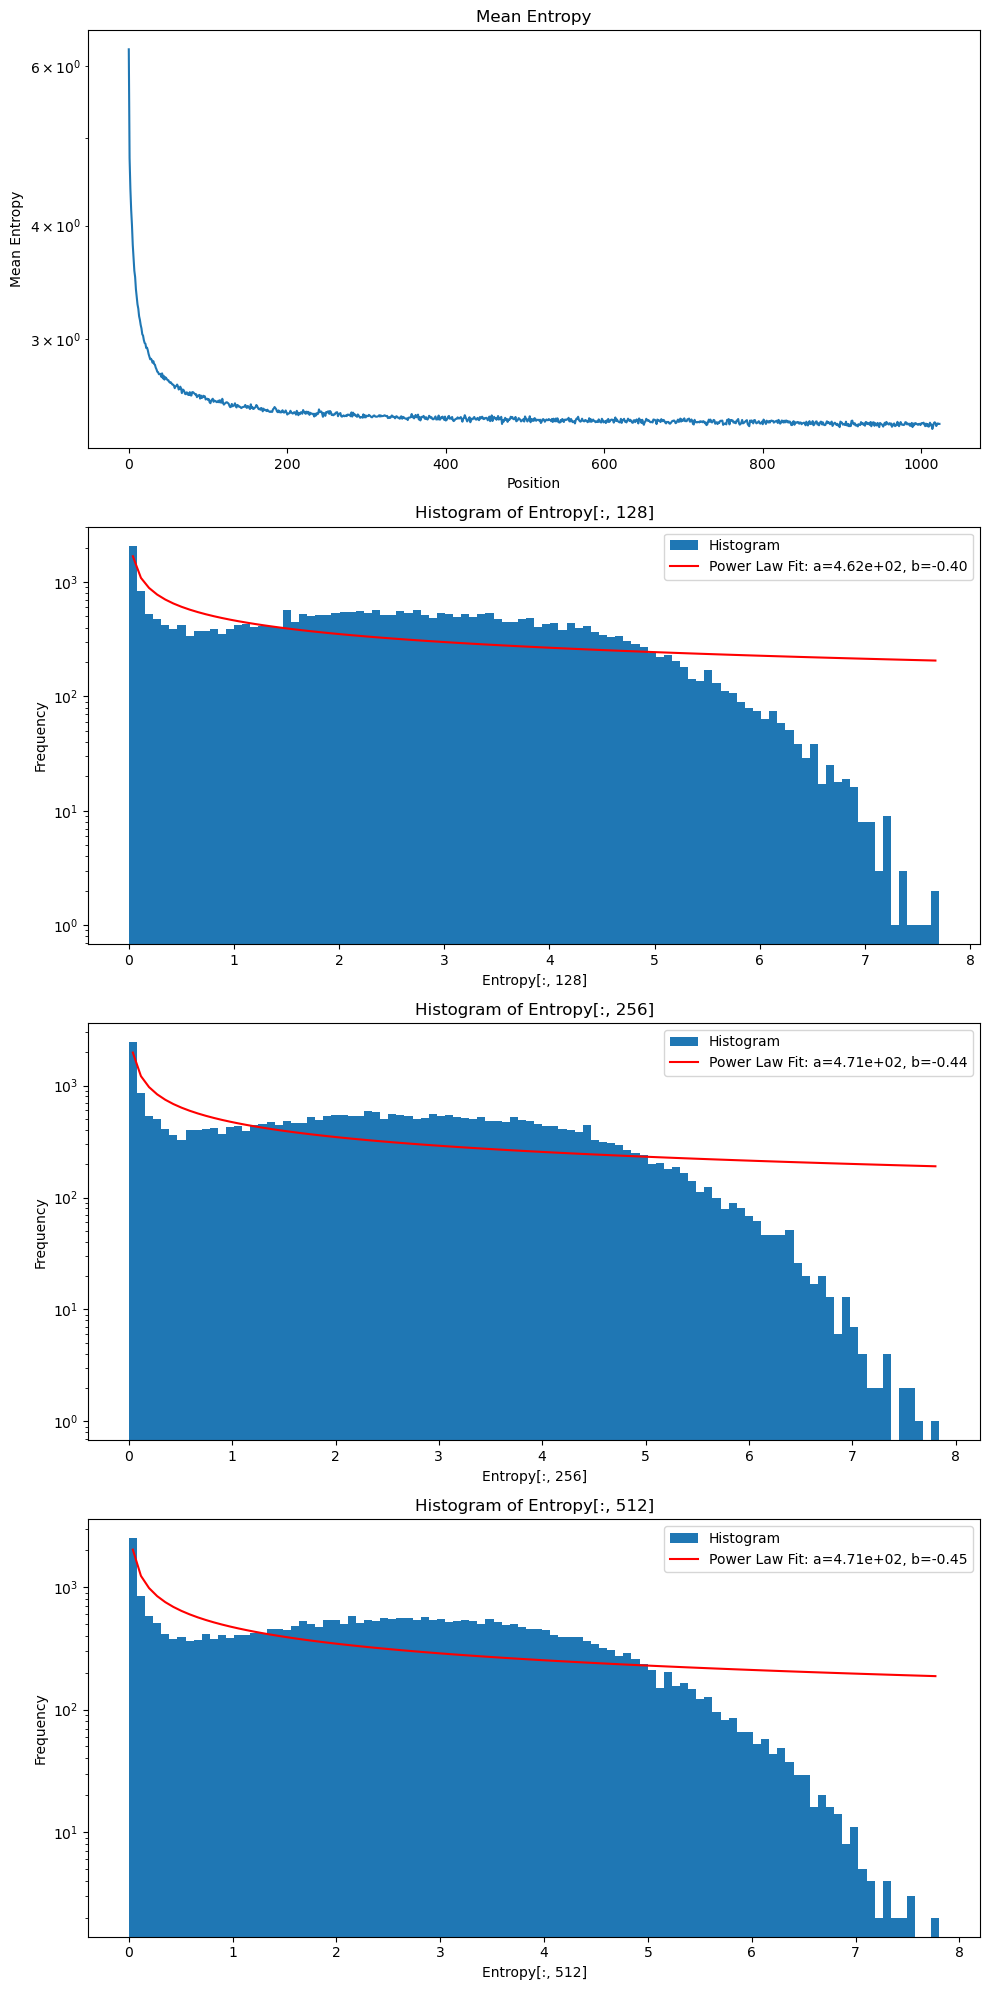

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assuming Entropy is a NumPy array
# Example: Entropy = np.random.rand(2000, 2048)  # Replace this with your actual data

# Define power law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Calculate the mean across the first axis
mean_Entropy = np.mean(Entropy, axis=0)

# Create a figure with subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot the mean Entropy
axs[0].plot(np.arange(1024), mean_Entropy[:1024])
axs[0].set_yscale('log')
axs[0].set_xlabel('Position')
axs[0].set_ylabel('Mean Entropy')
axs[0].set_title('Mean Entropy')

# Histograms and power law fitting for specific columns
columns = [128, 256, 512]
for i, col in enumerate(columns, 1):
    # Plot histogram
    hist, bins, _ = axs[i].hist(Entropy[:, col], bins=100, log=True, label='Histogram')
    
    # Calculate bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Fit power law to histogram data
    popt, _ = curve_fit(power_law, bin_centers, hist, maxfev=10000)
    
    # Plot the fitted power law line
    axs[i].plot(bin_centers, power_law(bin_centers, *popt), 'r-', label=f'Power Law Fit: a={popt[0]:.2e}, b={popt[1]:.2f}')
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel(f'Entropy[:, {col}]')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Histogram of Entropy[:, {col}]')
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()
